# Blended Model Using PyCaret 🤖...
...

## Installing Libraries...

In [1]:
%%capture
# !pip install --pre pycaret

---

## Loading Requiered Libraries...

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
%%time
from sklearn.impute import KNNImputer, SimpleImputer
from pycaret.classification import *
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler, SMOTE, SMOTENC, SVMSMOTE

CPU times: total: 2.58 s
Wall time: 3.18 s


---

## Configuring the Notebook...

In [4]:
%%time
# I like to disable my Notebook Warnings To Reduce Noice.
import warnings
warnings.filterwarnings('ignore')

CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
%%time
# Notebook Configuration...

# Amount of data we want to load into the Model...
DATA_ROWS = None
# Dataframe, the amount of rows and cols to visualize...
NROWS = 100
NCOLS = 15

# Main data location path...
BASE_PATH = '...'

CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
%%time
# Configure notebook display settings to only use 2 decimal places, tables look nicer.
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', NCOLS) 
pd.set_option('display.max_rows', NROWS)

CPU times: total: 0 ns
Wall time: 0 ns


---

## Loading the Datasets...

In [7]:
%%time
# Loading the datsets into Pandas
trn_data = pd.read_csv('../data/train.csv')
tst_data = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

CPU times: total: 188 ms
Wall time: 731 ms


---

## Exploring the Loaded Dataset...

In [8]:
trn_data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,...,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,...,15.19,15.03,NaN,13.03,14.68,764.10,0
1,1,A,84.89,material_7,material_8,9,5,...,11.76,14.73,15.43,14.39,15.63,682.06,0
2,2,A,82.43,material_7,material_8,9,5,...,13.80,16.71,18.63,14.09,17.95,663.38,0
3,3,A,101.07,material_7,material_8,9,5,...,10.02,15.25,15.56,16.15,17.17,826.28,0
4,4,A,188.06,material_7,material_8,9,5,...,12.43,16.18,12.76,13.15,16.41,579.88,0


In [9]:
%%time
# Identifying Categorical Faetures...
limit = 10 # Anything with more than 50 unique values is considered a category...
cat_feat = [feat for feat in trn_data.columns if trn_data[feat].nunique() < limit and feat not in ['failure', 'id', 'product_code']]
num_feat = [feat for feat in trn_data.columns if feat not in cat_feat and feat not in ['failure', 'id', 'product_code']]

print(f'Categorical Features: {cat_feat}')
print(f'Numerical Features: {num_feat} ...')

Categorical Features: ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']
Numerical Features: ['loading', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17'] ...
CPU times: total: 15.6 ms
Wall time: 21 ms


In [10]:
cat_feat = ['attribute_0', 'attribute_1']
num_feat = ['loading', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 
            'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 
            'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17','attribute_2', 'attribute_3']

In [11]:
%%time
# Identifying numeric columns
measure_cols = [col for col in trn_data.columns if 'meas' in col] + ['loading']
measure_cols

CPU times: total: 0 ns
Wall time: 0 ns


['measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17',
 'loading']

---

## Pre-processing The Dataset...

In [12]:
%%time
# Create a fill missing values function using the Simple Imputer
def imputer_numeric(df, cols, group_code = 'product_code'):
    '''
    
    '''
    product_list = list(df[group_code].unique())
    result_df = pd.DataFrame()
    for product in product_list:
        tmp = df[df[group_code] == product]
        print(f'Imputing for Product: {product}...')
        imputer = SimpleImputer(strategy = "mean")
        imputer.fit(tmp[cols])

        tmp[cols] = imputer.transform(tmp[cols])
        result_df = result_df.append(tmp)
        
    print('...........', '\n')
    return result_df

trn_data = imputer_numeric(trn_data, measure_cols, group_code = 'product_code')
tst_data = imputer_numeric(tst_data, measure_cols, group_code = 'product_code')

Imputing for Product: A...
Imputing for Product: B...
Imputing for Product: C...
Imputing for Product: D...
Imputing for Product: E...
........... 

Imputing for Product: F...
Imputing for Product: G...
Imputing for Product: H...
Imputing for Product: I...
........... 

CPU times: total: 125 ms
Wall time: 284 ms


---

## Building a Parameter file for PyCaret...

In [13]:
clf101 = setup(data = trn_data,
               target = 'failure',
               categorical_features = cat_feat,
               numeric_features = num_feat,
               normalize = True,
               normalize_method = 'robust',
               #pca = True,
               #polynomial_features = True,
               #feature_selection = True,
               #fix_imbalance = True,
               #fix_imbalance_method = SMOTE(),
               ignore_features = ['id', 'product_code'],
               session_id = 123) 

,Description,Value
0,Session id,123
1,Target,failure
2,Target type,Binary
3,Original data shape,"(26570, 24)"
4,Transformed data shape,"(26570, 26)"
5,Transformed train set shape,"(18598, 26)"
6,Transformed test set shape,"(7972, 26)"
7,Ignore features,2
8,Ordinal features,1
9,Numeric features,21


---

## Fit Multiple Models, Select the Best...

In [14]:
best_model = compare_models(sort = 'AUC', fold = 10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7869,0.5838,0.0030,0.2600,0.0060,0.0024,0.0119,0.1540
lr,Logistic Regression,0.7869,0.5833,0.0015,0.2167,0.0030,0.0008,0.0050,1.0300
gbc,Gradient Boosting Classifier,0.7868,0.5772,0.0028,0.2833,0.0055,0.0019,0.0099,2.8040
ada,Ada Boost Classifier,0.7861,0.5717,0.0048,0.3092,0.0094,0.0028,0.0126,0.7120
nb,Naive Bayes,0.7823,0.5711,0.0316,0.3689,0.0582,0.0250,0.0514,0.1230
lightgbm,Light Gradient Boosting Machine,0.7861,0.5593,0.0046,0.2610,0.0089,0.0025,0.0094,0.2950
rf,Random Forest Classifier,0.7870,0.5459,0.0010,0.2500,0.0020,0.0004,0.0040,2.2550
et,Extra Trees Classifier,0.7871,0.5448,0.0003,0.0500,0.0005,-0.0002,-0.0030,0.9710
knn,K Neighbors Classifier,0.7486,0.5116,0.0787,0.2316,0.1173,0.0107,0.0129,0.3060
dt,Decision Tree Classifier,0.6570,0.5061,0.2435,0.2212,0.2318,0.0116,0.0117,0.3060


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [15]:
print(best_model)

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)


---

## Fit a Machine Learning Model LDA...

In [16]:
lda = create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7871,0.5836,0.0051,0.5000,0.0100,0.0058,0.0326
1,0.7849,0.5580,0.0000,0.0000,0.0000,-0.0043,-0.0241
2,0.7860,0.5924,0.0000,0.0000,0.0000,-0.0021,-0.0171
3,0.7855,0.5563,0.0025,0.2000,0.0050,-0.0003,-0.0016
4,0.7871,0.5882,0.0051,0.4000,0.0100,0.0047,0.0238
5,0.7876,0.5856,0.0051,0.5000,0.0100,0.0058,0.0326
6,0.7876,0.5856,0.0076,0.5000,0.0150,0.0087,0.0400
7,0.7876,0.6151,0.0051,0.5000,0.0100,0.0058,0.0326
8,0.7875,0.6032,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

---

## Fit a Machine Learning Model LR...

In [17]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7866,0.5836,0.0000,0.0000,0.0000,-0.0011,-0.0121
1,0.7855,0.5568,0.0000,0.0000,0.0000,-0.0032,-0.0209
2,0.7866,0.5919,0.0000,0.0000,0.0000,-0.0011,-0.0121
3,0.7860,0.5558,0.0025,0.2500,0.0050,0.0007,0.0042
4,0.7887,0.5877,0.0051,1.0000,0.0101,0.0080,0.0632
5,0.7871,0.5849,0.0025,0.3333,0.0050,0.0018,0.0119
6,0.7866,0.5847,0.0025,0.2500,0.0050,0.0008,0.0043
7,0.7871,0.6146,0.0025,0.3333,0.0050,0.0018,0.0119
8,0.7875,0.6033,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
# trained model object is stored in the variable 'dt'. 
print(lda)

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)


In [19]:
# trained model object is stored in the variable 'dt'. 
print(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


---

## Optimize the Models, LDA & LR

In [20]:
tuned_lda = tune_model(lda)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7876,0.5837,0.0076,0.6000,0.0150,0.0097,0.0491
1,0.7849,0.5584,0.0000,0.0000,0.0000,-0.0043,-0.0241
2,0.7860,0.5930,0.0000,0.0000,0.0000,-0.0021,-0.0171
3,0.7860,0.5568,0.0051,0.3333,0.0100,0.0036,0.0167
4,0.7876,0.5881,0.0076,0.5000,0.0150,0.0087,0.0400
5,0.7876,0.5862,0.0051,0.5000,0.0100,0.0058,0.0326
6,0.7876,0.5849,0.0076,0.5000,0.0150,0.0087,0.0400
7,0.7876,0.6150,0.0051,0.5000,0.0100,0.0058,0.0326
8,0.7870,0.6032,0.0000,0.0000,0.0000,-0.0011,-0.0121


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [21]:
tuned_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7866,0.5836,0.0000,0.0000,0.0000,-0.0011,-0.0121
1,0.7855,0.5568,0.0000,0.0000,0.0000,-0.0032,-0.0209
2,0.7866,0.5919,0.0000,0.0000,0.0000,-0.0011,-0.0121
3,0.7860,0.5559,0.0025,0.2500,0.0050,0.0007,0.0042
4,0.7887,0.5877,0.0051,1.0000,0.0101,0.0080,0.0632
5,0.7871,0.5849,0.0025,0.3333,0.0050,0.0018,0.0119
6,0.7871,0.5847,0.0051,0.4000,0.0100,0.0047,0.0238
7,0.7871,0.6146,0.0025,0.3333,0.0050,0.0018,0.0119
8,0.7875,0.6033,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [22]:
# tuned model object is stored in the variable 'tuned_dt'. 
print(tuned_lda)

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=0.1, solver='eigen',
                           store_covariance=False, tol=0.0001)


In [23]:
# tuned model object is stored in the variable 'tuned_dt'. 
print(tuned_lr)

LogisticRegression(C=7.863, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


---

## Visualize of the Model Results...

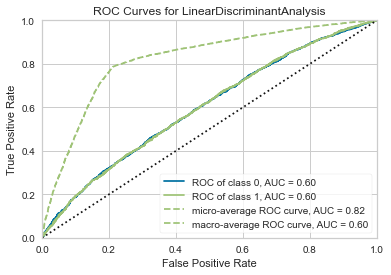

In [24]:
plot_model(tuned_lda, plot = 'auc')

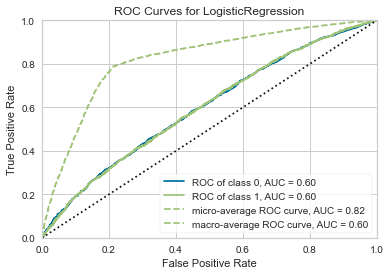

In [25]:
plot_model(tuned_lr, plot = 'auc')

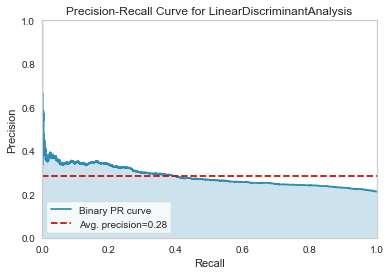

In [26]:
plot_model(tuned_lda, plot = 'pr')

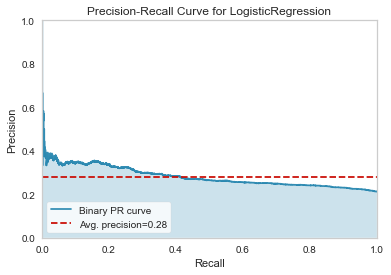

In [27]:
plot_model(tuned_lr, plot = 'pr')

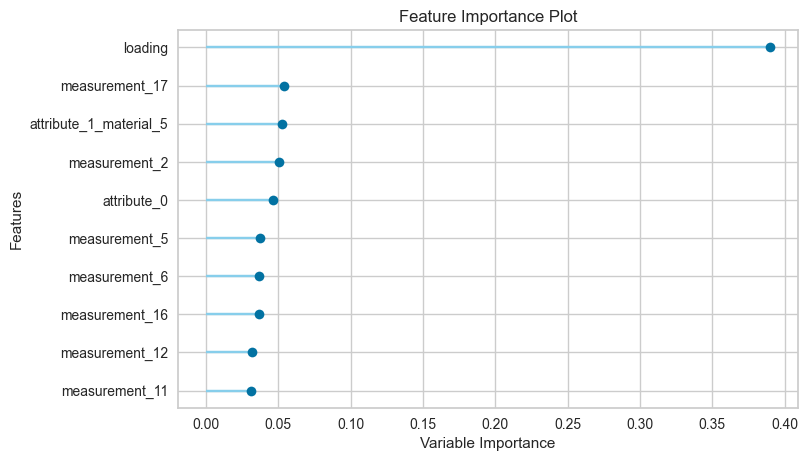

In [28]:
plot_model(tuned_lda, plot='feature')

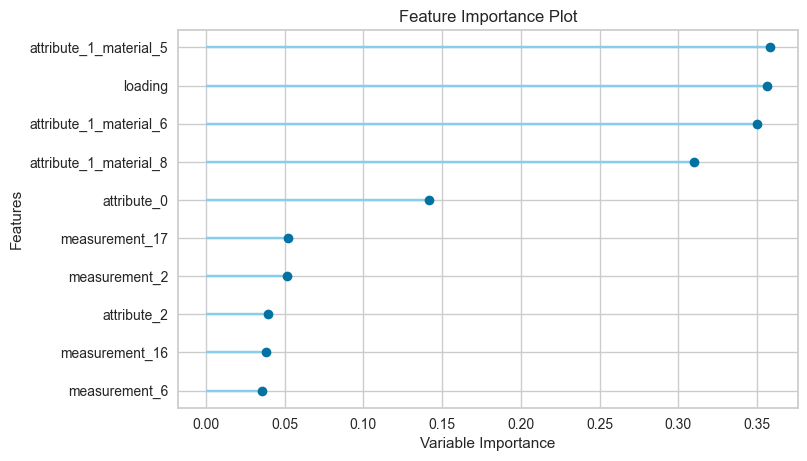

In [29]:
plot_model(tuned_lr, plot='feature')

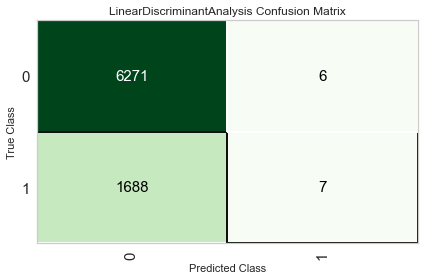

In [30]:
plot_model(tuned_lda, plot = 'confusion_matrix')

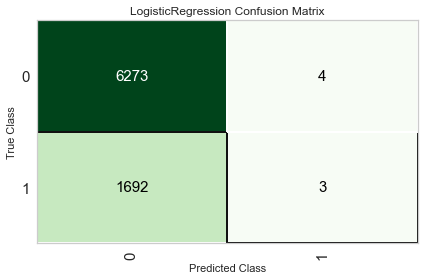

In [31]:
plot_model(tuned_lr, plot = 'confusion_matrix')

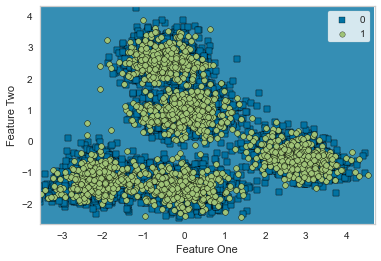

In [32]:
plot_model(tuned_lda, plot = 'boundary')

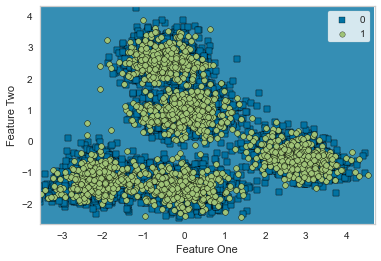

In [33]:
plot_model(tuned_lr, plot = 'boundary')

---

## Creating Blend of the Selected Models...

In [34]:
# blend models
blender = blend_models([tuned_lda, tuned_lr])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7866,0.5836,0.0000,0.0000,0.0000,-0.0011,-0.0121
1,0.7849,0.5576,0.0000,0.0000,0.0000,-0.0043,-0.0241
2,0.7860,0.5925,0.0000,0.0000,0.0000,-0.0021,-0.0171
3,0.7860,0.5564,0.0025,0.2500,0.0050,0.0007,0.0042
4,0.7876,0.5879,0.0051,0.5000,0.0100,0.0058,0.0326
5,0.7876,0.5856,0.0051,0.5000,0.0100,0.0058,0.0326
6,0.7876,0.5849,0.0076,0.5000,0.0150,0.0087,0.0400
7,0.7876,0.6149,0.0051,0.5000,0.0100,0.0058,0.0326
8,0.7875,0.6032,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

---

## Finalize the Model by Training in the Full Dataset...

In [35]:
final_blended = finalize_model(blender)

In [36]:
#final_lda = finalize_model(tuned_lda)

In [37]:
#final_lr = finalize_model(tuned_lda)

In [38]:
#Final Random Forest model parameters for deployment
print(final_blended)

Pipeline(memory=Memory(location=C:\Users\Vadim\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['loading', 'measurement_0',
                                             'measurement_1', 'measurement_2',
                                             'measurement_3', 'measurement_4',
                                             'measurement_5', 'measurement_6',
                                             'measurement_7', 'measurement_8',
                                             'measurement_9', 'measurement_10',
                                             'measurement_11', 'me...
                                              ('Logistic Regression',
                                               LogisticRegression(C=7.863,
                                                                  class_weight={},
                                                                  dual

---

## Generate Predictions Using the Final Model...

In [39]:
predict_model(final_blended);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7876,0.6049,0.0047,0.5714,0.0094,0.0059,0.0368


In [40]:
# Linear Discriminant Analysis	0.7874	0.5994

In [41]:
unseen_predictions = predict_model(final_blended, data = tst_data, raw_score = False)
unseen_predictions.sample(25)

,loading,attribute_0,attribute_1_material_6,attribute_1_material_5,attribute_1_material_8,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,Label,Score
4079,-0.32,-1.00,1.00,0.00,0.00,0.00,-2.00,0.50,0.67,1.25,...,-0.47,-0.54,0.31,-1.02,0.12,-0.11,0.38,-0.58,0,0.82
13271,-0.99,0.00,0.00,0.00,0.00,0.50,0.50,-0.67,-0.17,-1.50,...,0.73,-0.08,-0.98,-0.03,0.01,-0.35,0.56,-0.54,0,0.85
17609,-0.25,0.00,0.00,1.00,0.00,1.50,-1.50,-1.00,0.00,0.25,...,-0.41,0.93,0.61,0.84,-0.22,0.07,0.95,-1.23,0,0.82
19915,0.55,0.00,0.00,1.00,0.00,1.50,-1.50,-0.67,-0.33,-1.00,...,0.91,0.63,1.60,0.85,-0.40,-0.52,0.33,0.13,0,0.77
8161,-1.02,-1.00,1.00,0.00,0.00,1.50,-0.50,-1.00,-1.00,-0.50,...,-0.05,0.02,-0.52,-0.09,-1.64,1.01,0.67,-3.11,0,0.90
1336,-0.27,-1.00,1.00,0.00,0.00,0.00,-2.00,-0.50,0.00,0.50,...,-0.75,0.11,0.07,0.25,-1.03,-0.11,0.87,-1.83,0,0.84
4011,1.81,-1.00,1.00,0.00,0.00,0.00,-2.00,-0.33,0.83,1.50,...,-0.56,-0.31,0.16,-0.08,-0.13,-0.62,1.03,-0.31,0,0.66
17564,-0.01,0.00,0.00,1.00,0.00,1.50,-1.50,-0.17,0.17,-0.25,...,0.37,-0.34,0.84,-1.31,0.68,-0.31,-0.66,0.05,0,0.78
12061,-0.02,0.00,0.00,0.00,0.00,0.50,0.50,0.33,-0.83,-0.25,...,1.62,0.10,0.11,-0.45,1.02,-0.65,0.29,-0.02,0,0.76
799,-0.58,-1.00,1.00,0.00,0.00,0.00,-2.00,0.50,0.67,1.50,...,1.59,-0.42,-0.08,-0.02,0.85,1.25,-0.11,0.00,0,0.82


---

## Create a Submission File...

In [42]:
%%time
# ...
submission['failure'] = 1 - unseen_predictions['Score']
submission.to_csv('pycaret_lda_submission.csv', index = False)
submission.head()  

CPU times: total: 62.5 ms
Wall time: 224 ms


,id,failure
0,26570,0.20
1,26571,0.15
2,26572,0.18
3,26573,0.18
4,26574,0.34


---